In [1]:
import os
import sys
PATH = '.'
START = '2020_02_23'
END = '2020_07_15'
PATH_DATA = os.path.join(PATH, 'data/clean')

In [57]:
import os
import ast
import sys
import re
import json
import pickle
from itertools import chain
import gc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk import FreqDist
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import seaborn as sns
from functools import partial



sys.path.append(os.path.join(PATH, 'src'))
from twitter_tools.utils import read_files, clean_tweets
from tqdm.notebook import tqdm
tqdm.pandas()

PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_tweets.json')
drop_tweets = json.load(open(PATH_DROP, 'r'))
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_users.json')
drop_users = json.load(open(PATH_DROP, 'r'))

# filter function:
def filter_fun(df:pd.DataFrame, drop_users:list, 
               drop_tweets:list, drop_duplicates:bool = True, 
               keep_cols:list = None, **kwargs):
    """
    Function to filter the read data frame.
    df - pd.DataFrame 
    drop_users:list - IDs of users to drop
    drop_tweets: list - IDs of tweets to drop
    drop_duplicates: bool, whether to drop duplicates
    keep_cols: columns to keep. If None, keeps all
    **kwargs - provided to the pd.DataFrame.drop_duplicates method
    
    """
    df = df[np.logical_not(df['user-id_str'].isin(drop_users))] #drop IDs that are to be excluded
    df = df[np.logical_not(df['id_str'].isin(drop_tweets))]
    if drop_duplicates:
        df.drop_duplicates(inplace = True, **kwargs)
    if keep_cols is not None:
        df = df[keep_cols]
    return df

# partial filter function, with preset filters
ff = partial(filter_fun, drop_users=drop_users, drop_tweets=drop_tweets, drop_duplicates=True)

In [58]:
PATH_STOPWORDS = '/home/piotr/nlp/polish.stopwords.txt'
stopwords = []
with open(PATH_STOPWORDS, 'r') as f:
    for line in f:
        stopwords.append(line.strip('\n'))
stopwords.append('mieć')

#### Load the data:

In [107]:
counts = dict()
for data in tqdm(read_files(PATH_DATA, day_from=START, day_to=END, dtype={'retweet':bool}, filter_fun=ff)):
    counts[data['day'].unique()[0], 'retweets'] = data.groupby(['source']).agg({'retweet':'sum'}).retweet.to_dict()
    counts[data['day'].unique()[0], 'total'] = data.groupby('source').size().to_dict()

In [117]:
(pd.DataFrame(counts)
 .melt(ignore_index=False, var_name=['date','type'])
 .reset_index()
 .rename(columns={'index':'source'})
 .pivot(index=['source','date'], columns=['type'], values='value')
 .reset_index().groupby('source').agg('sum'))

type,retweets,total
source,,
gov,2547173,4714664
opp,2340673,4401408


In [130]:
counts = pd.DataFrame()
for data in tqdm(read_files(PATH_DATA, day_from=START, day_to=END, dtype={'user-id_str':str}, filter_fun=ff)):
    counts = counts.append(data[['source','user-id_str']].drop_duplicates())
counts.reset_index(inplace=True, drop=True)

In [134]:
counts.drop_duplicates().groupby('source').size()

source
gov    4870
opp    4843
dtype: int64

## 1. Analysis of the entire dataset:

[########################################] | 100% Completed |  2min  1.6s


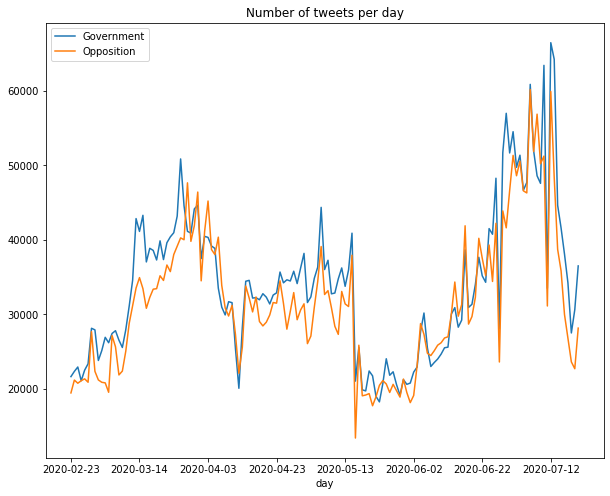

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
with ProgressBar():
    data_plot = data.groupby(["day", "source"]).size().compute(num_workers = 4).reset_index('source').pivot(columns = "source")
data_plot.plot(ax = ax)
ax.legend(['Government', 'Opposition'])
ax.set_title('Number of tweets per day')
plt.show()

### Vocabulary distribution (lemmatized and without stopwords)
In the first step of the exploratory analysis, I look at the frequency distribution of lemmas in the entire corpus (with exclusion of stopwords, which were removed at the preprocessing step). 

#### Overall distribution (based on random sample of 10% Tweets)

In [5]:
lem_remove = lambda x: [w for w in x.split() if w not in stopwords]

In [ ]:
data = read_files(PATH_DATA, day_from=START, day_to=END, method='dask', dtype=str)

In [8]:
"""
with ProgressBar():
    sample = data.groupby(['day','source']).apply(lambda x: x.sample(round(0.1 * x.shape[0])), meta = ('lemmatized', 'object')).compute()

lemmatized = sample.lemmatized.astype(str).progress_apply(lem_remove)
"""
sample = pd.DataFrame()
for dat in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, method = 'pandas', dtype = str)):
    smp = dat.sample(int(0.1 * dat.shape[0]), random_state = 1234)
    smp.loc[:,('lemmatized')] = smp.lemmatized.astype(str).apply(lem_remove)
    sample = sample.append(smp)

Get the overall top 50 tokens and plot their split by group

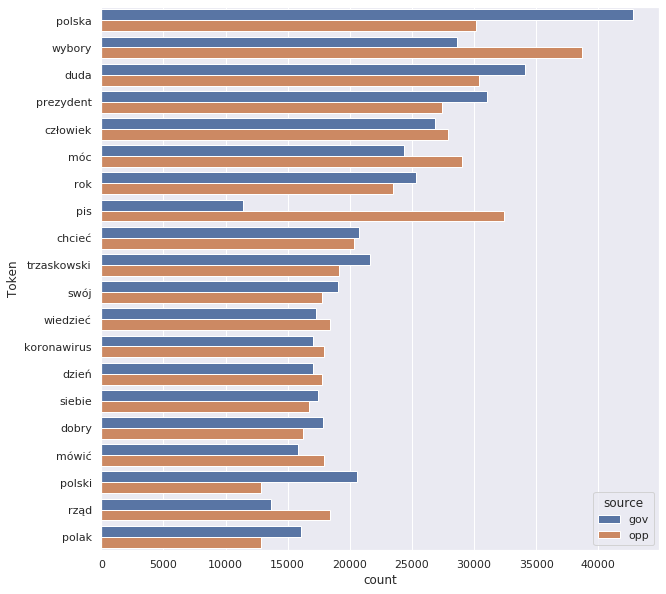

In [81]:
freq = FreqDist(list(chain.from_iterable(sample.lemmatized.tolist())))
most_common = [w for w, c in freq.most_common(20)]
by_group = dict()
for source, df in sample.groupby('source'):
    dist_party = FreqDist(list(chain.from_iterable(df.lemmatized.tolist())))
    by_group[source] = pd.DataFrame([(word, dist_party[word]) for word in most_common], columns = ['word','count'])
counts = by_group['gov'].merge(by_group['opp'], on = 'word', suffixes = ('_gov','_opp')).melt('word')
counts.columns = ['word','source','count']
counts['source'] = counts.source.str.replace('count_','')
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
sns.barplot(y = 'word',x = 'count', hue = 'source', data = counts, ax = ax)
ax.set_ylabel('Token')
plt.show()

### Vocabulary distribution by party by week

In [10]:
data['week'] = dd.to_datetime(data['day'], format = '%Y-%m-%d').dt.week
word_counts = defaultdict(dict)
get_dist = lambda x: FreqDist(chain.from_iterable(lem_remove(x).tolist()))
task = data.groupby(['source','week']).apply(get_dist, meta = ('lemmatized','object'))
future = client.compute(task)
future = future.result()

In [55]:
%matplotlib inline
fig, ax = plt.subplots(4, 4, figsize = (15, 15))
ax = ax.ravel()
for i, (week, counts) in enumerate(word_counts.items()):
    pd.DataFrame(counts).plot.barh(ax = ax[i])
    ax[i].set_title(f'Week {week}')
plt.tight_layout()
plt.show()

### Party-specific vocabulary distribution
Secondly, I look at party-specific vocabulary, defined as tokens that were included in the top 100 most frequent tokens of one party, but not the other. Again, stopwords are not included.

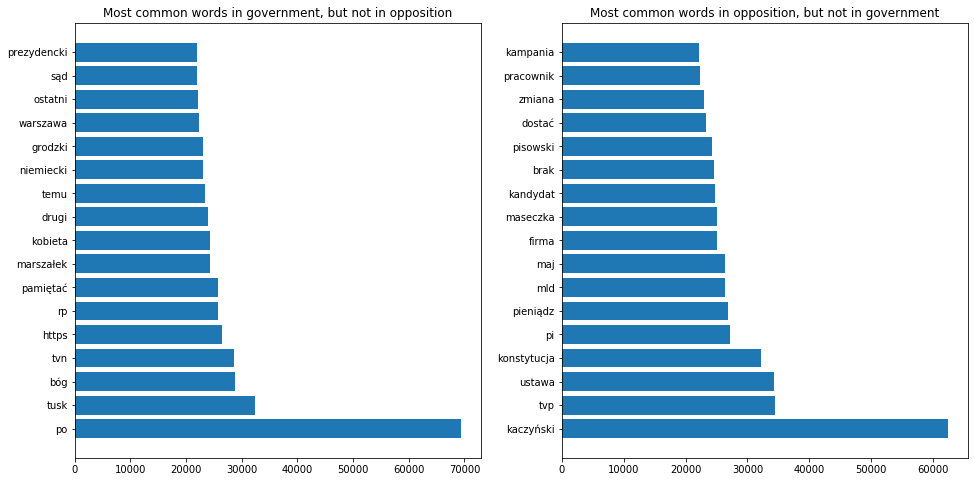

In [11]:
freqs = dict() #store freq dist for both parties
for source in ["gov","opp"]:
    freqs[source] = FreqDist(list(itertools.chain.from_iterable([tweet 
                                          for i, tweet in enumerate(data["preprocessed"].tolist()) 
                                          if data["source"].iloc[i] == source])))

words = dict() #store "unique" tokens for both parties
words["gov"] = [word for word in freqs["gov"].most_common(100) if word[0] not in [elem[0] for elem in freqs["opp"].most_common(100)]]
words["opp"] = [word for word in freqs["opp"].most_common(100) if word[0] not in [elem[0] for elem in freqs["gov"].most_common(100)]]

%matplotlib inline
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Most common words in government, but not in opposition")
ax.barh(y = [word[0] for word in words["gov"]], width = [word[1] for word in words["gov"]])
ax = fig.add_subplot(1, 2, 2)
ax.set_title("Most common words in opposition, but not in government")
ax.barh(y = [word[0] for word in words["opp"]], width = [word[1] for word in words["opp"]])
plt.show()

The main conclusion seems to be that names of politicians and entities related to one's opposing party are mentioned more frequently than to one's party. This relates to both individual politicians ("Kaczynski", "Tusk") as well as news broadcasters ("tvp", "tvn").

#### Plot of the frequency of topic-related tokens

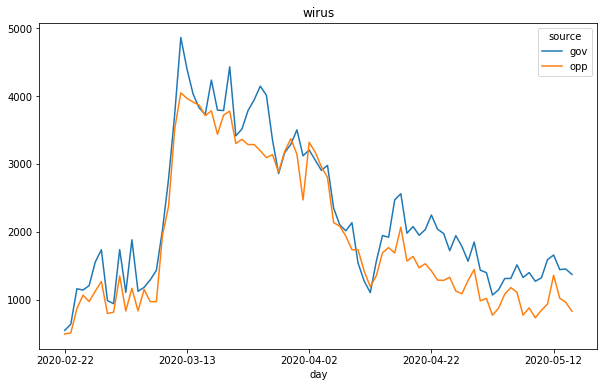

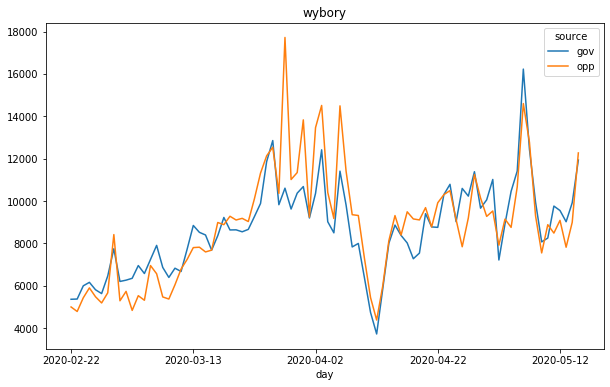

In [162]:
topic_counts = data.groupby(["source","day"]).sum()
ax = topic_counts.reset_index() \
                                .melt(id_vars = ["day", "source"], 
                                      value_vars = ["wirus", "wybory"], 
                                      var_name = ["topic"]) \
                                .pivot_table(index = ["day","topic"], 
                                             columns = ["source"], 
                                             values = "value") \
                                .reset_index().groupby("topic").plot(x = "day", figsize = (10,6))
_ = [ax[i].set_title(ax.index[i]) for i in range(len(ax))]
plt.show()